#### **This notebook creates the hashtag bi-partite graph**

https://docs.google.com/document/d/1xU3G8P9kFfqXwQ8H_pkx-eIVownycBrIGm54JADjyTs/edit

In [1]:
import pandas as pd
import numpy as np
import os
import importlib

#### **Load Datasets and Check for Control**

In [62]:
io_path = '/N/project/INCAS/new_parse/io/cuba_082020_tweets.pkl.gz'
control_path = '/N/project/INCAS/new_parse/control/cuba_082020_tweets_control.pkl.gz'

#### **Load Cuba Datasets**

In [3]:
import re

#### **Get hashtag bi-partite network**

In [101]:
def filter_user(df, min_activity=10):
    '''
    Filters the user based on number of activity
    :param df: Dataframe
    '''
    df_grp = (df
              .groupby(['userid'])['tweetid']
              .nunique()
              .to_frame('count')
              .reset_index()
             )
    
    df_grp = df_grp.loc[df_grp['count'] >= min_activity]
    
    df = df.loc[df['userid'].isin(df_grp['userid'])]
    
    print(f'After filtering user with min activity {min_activity}')
    
    df_1 = df.loc[df['label'] == 1]
    df_0 = df.loc[df['label'] == 0]
    
    print('Class 1: ', len(df_1))
    print('Class 2: ', len(df_0))
    
    return df
    
def get_original_tweet(df):
    '''
    Gets the original tweets only.
    :param df: DataFrame
    
    :return DataFrame
    '''
    is_retweet = df['is_retweet'] == False
    in_reply_to_tweetid = df['in_reply_to_tweetid'].isnull()
    # quoted_tweet_tweetid = df['quoted_tweet_tweetid'].isnull()
    
    return df.loc[is_retweet & ~in_reply_to_tweetid]

def filter_tweets_with_hashtag(df):
    '''
    Gets tweets with hashtag and convert the string hashtag to list
    :param df: DataFrame
    
    :return DataFrame
    '''
    import ast
    
    df_hashtag = df.loc[
        (~df['hashtags'].isnull()) & (df['hashtags'] != '[]')
    ]
    
    df_hashtag['list_hashtag'] = df_hashtag['hashtags'].apply(
        lambda x: ast.literal_eval(x)
    )
    
    print(df_hashtag['label'].nunique())
    
    return df_hashtag

def get_bipartite(df, columns):
    return list(zip(*[df[col] for col in columns]))

def load_file(io_path, control_path):
    '''
    Load io or control file or both
    :param io_path: Path to IO file
    :param control_path: Path to Control file
    
    :return DataFrame
    '''
    # columns = ['hashtags', 'userid', 'tweetid', 'label']
    
    if io_path == None:
        df = pd.read_pickle(control_path)
        df['hashtags'] = df['hashtags'].astype(str)
        df['label'] = 0
        
        return df
    elif control_path == None:
        df = pd.read_pickle(io_path)
        df_io = df_io.loc[
            ~df_io['quoted_tweet_tweetid'].isnull()
        ]
        df['label'] = 1
        
        return df
        
    if io_path != None and control_path != None:
        df_control = pd.read_pickle(control_path)
        df_control['hashtags'] = df_control['hashtags'].astype(str)
        df_control['label'] = 0
        
        df_io = pd.read_pickle(io_path)
        df_io = df_io.loc[
            ~df_io['quoted_tweet_tweetid'].isnull()
        ]
        df_io['label'] = 1
        
        print('Total control data: ', len(df_control))
        print('Total IO data: ', len(df_io))
        
        df = pd.concat([df_control, df_io],
                       ignore_index=True
                      )
        return df
    

def preprocess_data(io_path, control_path, min_activity):
    '''
    Loads, filter original tweets and filter tweets with
    hashtags
    :param io_path: Path to IO file
    :param control_path: Path to Control File
    
    :return DataFrame
    '''
    df = load_file(io_path, control_path)
    print('Loading data, class: ', df['label'].nunique())
    
    df = get_original_tweet(df)
    print('Filtering original tweet, class: ', 
          df['label'].nunique())
    
    df = filter_tweets_with_hashtag(df)
    print('Filtering tweet with hashtag, class: ', 
          df['label'].nunique())
    
    #filter user based on number of tweets with hashtags
    df = filter_user(df, min_activity=min_activity)
    print(f'Filtering the user with min activity {min_activity}, class: ', 
          df['label'].nunique())
    
    return df

def save_bipartite(tuple_list, save_path):
    '''
    Saves the bipartite graph as json
    :param tuple_list: List of tuple
    :param save_path: Path to save the file
    
    :return None
    '''
    import json

    with open(f'{save_path}', 'w') as f:
        json.dump(tuple_list, f)

    
def get_hashtags_bipartite(io_path, 
                           control_path, 
                           save_path, 
                           min_activity=10
                          ):
    '''
    Gets the bi-partite network of user and hashtags
    :param path: Path to the file
    
    :return list of tuple (user, hashtag)
    '''
    df = preprocess_data(io_path, control_path, min_activity)
    
    df_1 = df.loc[df['label'] == 1]
    df_0 = df.loc[df['label'] == 0]
    
    print('Total activity after filtering for IO:', len(df_1))
    print('Total activity after filtering for Control:', len(df_0))
    
    df = df.explode(['list_hashtag'])

    print(df.head())
    
    bipartite_graph = get_bipartite(df,
                                    ['userid','list_hashtag','label']
                                   )
#     print(df.head())
#     print(len(df))
#     print(bipartite_graph[:5])
    
    save_bipartite(bipartite_graph, save_path)
    
    return df


def visualize_original_tweet(io_path, control_path):
    df = load_file(io_path, control_path)
    df = get_original_tweet(df)
    df = filter_tweets_with_hashtag(df)
    
    return df

#### **Get Bipartite network**

In [103]:
df = load_file(io_path, control_path)
print('Loading data, class: ', df['label'].nunique())

Total control data:  1353088
Total IO data:  250367
Loading data, class:  2


In [104]:
df_org = get_original_tweet(df)
print('Filtering original tweet, class: ', 
      df['label'].nunique())

Filtering original tweet, class:  2


In [ ]:
df_hash = filter_tweets_with_hashtag(df_org)
print('Filtering tweet with hashtag, class: ', 
      df_hash['label'].nunique()
     )

In [110]:
df_filter = filter_user(df_hash, min_activity=10)
print(f'Filtering the user with min activity 10, class: ', 
      df_filter['label'].nunique()
     )

After filtering user with min activity 10
Class 1:  654
Class 2:  390640
Filtering the user with min activity 10, class:  2


#### **With min activity 10**

In [111]:
save_path = '/N/project/INCAS/merge_network/cuba_bipartite_original_filter_10.json'

df = get_hashtags_bipartite(io_path, control_path, 
                            save_path, min_activity=10)

Total control data:  1353088
Total IO data:  250367
Loading data, class:  2
Filtering original tweet, class:  2
2
Filtering tweet with hashtag, class:  2
After filtering user with min activity 10
Class 1:  654
Class 2:  390640
Filtering the user with min activity 10, class:  2
Total activity after filtering for IO: 654
Total activity after filtering for Control: 390640
        tweetid                                         tweet_text  \
1   24148595306  @yghome ¿Fidel estaba en directo en TV? me lo ...   
1   24148595306  @yghome ¿Fidel estaba en directo en TV? me lo ...   
9   24121887538  @tanialatwitera Solo en EEUU 49 millones se ma...   
10  24121817827  @tanialatwitera El modelo capitalista://El mod...   
11  24121693342  @Alecarlo q permita llevar felizmente adelante...   

   in_reply_to_tweetid in_reply_to_userid                      created_at  \
1                 None           71024346  Fri Sep 10 23:59:48 +0000 2010   
1                 None           71024346  Fri Sep 10

#### **With min activity zero**

In [112]:
save_path = '/N/project/INCAS/merge_network/cuba_bipartite_original_filter_0.json'

df = get_hashtags_bipartite(io_path, control_path, 
                            save_path, min_activity=0)

Total control data:  1353088
Total IO data:  250367
Loading data, class:  2
Filtering original tweet, class:  2
2
Filtering tweet with hashtag, class:  2
After filtering user with min activity 0
Class 1:  771
Class 2:  435050
Filtering the user with min activity 0, class:  2
Total activity after filtering for IO: 771
Total activity after filtering for Control: 435050
        tweetid                                         tweet_text  \
1   24148595306  @yghome ¿Fidel estaba en directo en TV? me lo ...   
1   24148595306  @yghome ¿Fidel estaba en directo en TV? me lo ...   
9   24121887538  @tanialatwitera Solo en EEUU 49 millones se ma...   
10  24121817827  @tanialatwitera El modelo capitalista://El mod...   
11  24121693342  @Alecarlo q permita llevar felizmente adelante...   

   in_reply_to_tweetid in_reply_to_userid                      created_at  \
1                 None           71024346  Fri Sep 10 23:59:48 +0000 2010   
1                 None           71024346  Fri Sep 10 2

#### **Check JSON**

In [113]:
import json

# Load JSON data from file
save_path = '/N/project/INCAS/merge_network/cuba_bipartite_original_filter_0.json'

with open(save_path, 'r') as f:
    json_data = json.load(f)
    
print(json_data[:5])

[['41929478', 'Cuba', 0], ['41929478', 'Venezuela', 0], ['41929478', 'Cuba', 0], ['41929478', 'Cuba', 0], ['41929478', 'Cuba', 0]]


#### **Visualize the original tweet**

In [69]:
df = visualize_original_tweet(io_path, control_path)

In [70]:
df_1 = df_hash.loc[df_hash['label'] == 1]
df_0 = df_hash.loc[df_hash['label'] == 0]

In [71]:
df_1_grp = (df_1
            .groupby(['userid'])['tweetid']
            .nunique()
            .to_frame('count')
            .reset_index()
           )
df_0_grp = (df_0
            .groupby(['userid'])['tweetid']
            .nunique()
            .to_frame('count')
            .reset_index()
           )


In [72]:
df_0_grp.head()

,userid,count
0,1000007376,2
1,1000038557665320960,4
2,1000070078350708737,29
3,1000100707,155
4,1000138169482924032,6


In [10]:
import coordinationz.experiment_utilities as czexp

./plots/CCDF_cuba_original_tweet.png


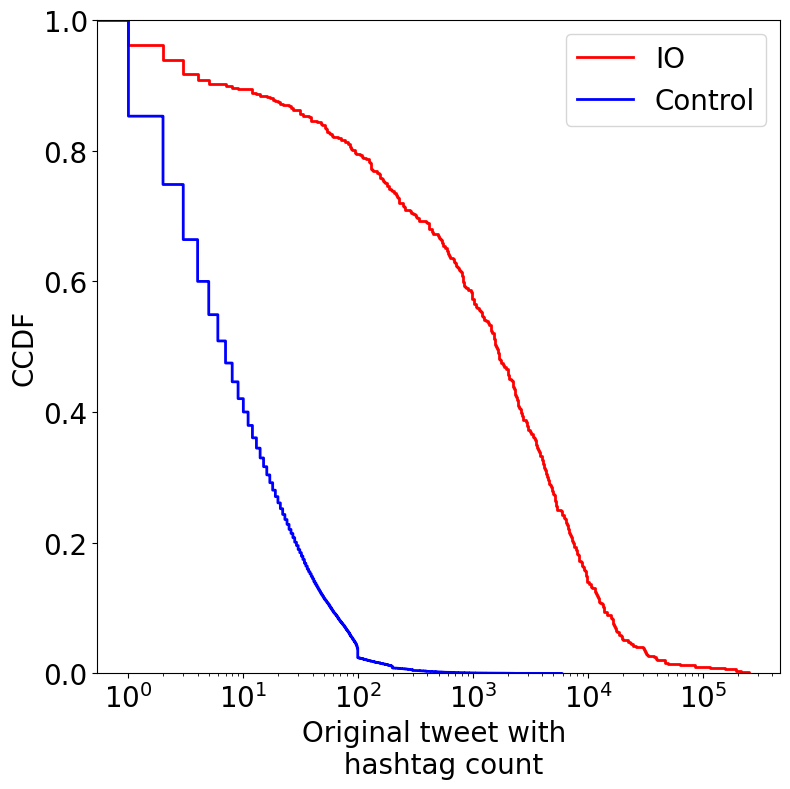

In [76]:
import helper.visualization as vz

parameters = {
        'data': [df_1_grp, 
                 df_0_grp
                ],
        'fontsize': 20,
        'complementary': True,
        'columns': [
            {'column': 'count',
             'label': 'IO',
            },{
            'column': 'count',
             'label': 'Control'
            },
        ],
        'xlabel': 'Original tweet with \n hashtag count',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        # 'log_yscale': True,
        'log_xscale': True,
        'save': {
            'path': './plots',
            'filename': 'CCDF_cuba_original_tweet.png'
        },
        'random_color': False
}

vz.ccdf(parameters)

In [ ]:
# df = get_hashtags(io_path, control_path)
